# Статистика, DS-поток
## Задание SP.1

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.


**Баллы за задание:**

* Задача 1 &mdash; 50 баллов
* Задача 2 &mdash; 20 баллов
* Задача 3 &mdash; 50 баллов
* Задача 4 &mdash; 80 баллов

**Важность задач:**

* *высокая:* задачи 3;
* *средне-высокая:* задачи 1, 4;
* *обычная* задачи 2.

Степень важности задач не связана с количеством баллов и определяется только на основе оценки полезности задачи с точки зрения усвоения текущего и дальнейшего материала. Например, если вы что-то не успеваете, рекомендуется в первую очередь выполнять более важные задачи.

In [1]:
# Bot check

# HW_ID: ds_sp1
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

import time

sns.set(palette='Set2')

---
## Задача 1.

Реализуйте метод Монте-Карло и метод прямоугольников численного интегрирования функций, используя приведенный ниже шаблон. Реализация должна уметь оценивать интегралы вида
$$ \int\limits_{\ell_1}^{h_1} ... \int\limits_{\ell_d}^{h_d} f(x_1, ... , x_d)\ dx_1 ... dx_d $$
для произвольной заданной функции $f$.

Реализация получает на вход векторы $\ell = (\ell_1, ... , \ell_d)$ и $h = (h_1, ... ,h_d)$, а также число $n$ &mdash; количество итераций оценки интеграла. В случае метода прямоугольников число итераций равно количеству используемых прямоугольников, а в случае метода Монте-Карло &mdash; размеру генерируемой выборки. 

*Требования:*
1. Значение функции $f$ можно посчитать только в $n$ точках.
2. Реализация не должна использовать какие-либо циклы, кроме циклов по числу интегралов $d$.
3. Для ускорения вычислений генерацию случайных чисел стоит производить с помощью `numpy.random`.
4. При реализации метода прямоугольников используйте равномерное разбиение по каждой координатной оси.

*Подсказка:* при реализации метода Монте-Карло обрати внимание на один из примеров с лекции.

Для быстрой работы метода прямоугольников используйте функцию <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html">`numpy.meshgrid`</a>. Ниже есть пример ее использования. 

In [3]:
# Предположим, мы хотим получить координаты всех целых точек (x, y), 
# таких, что x лежит в промежутке [5, 6], а y - в промежутке [-3, -1]

linspace_x = [5, 6]  
linspace_y = [-3, -2, -1]

# возвращает матрицы с координатами сетки,
# задаваемой проекциями точек на оси координат
X, Y = np.meshgrid(linspace_x, linspace_y)

print("X: ", X)  # linspace_x повторилась len(linspace_y) раз по оси 0
print("Y: ", Y)  # linspace_y повторилась len(linspace_x) раз по оси 1


# преобразуем исходный формат к вектору точек
np.stack([X, Y]).reshape(2, -1).T

X:  [[5 6]
 [5 6]
 [5 6]]
Y:  [[-3 -3]
 [-2 -2]
 [-1 -1]]


array([[ 5, -3],
       [ 6, -3],
       [ 5, -2],
       [ 6, -2],
       [ 5, -1],
       [ 6, -1]])

In [4]:
class Integrator:

    @staticmethod
    def integrate(func, low, high, n_iter, method="rectangle"):
        """
        Оценка определенного интеграла.

        Аргументы:
        f --- векторная функция d-мерной переменной.
            Реализация функции на вход принимает матрицу (n, d),
            где n - число точек, в которых нужно вычислить функцию,
            а d - размерность пространства переменных.
            Функция должна вернуть вектор размерности n.
        low, high --- нижние и верхние пределы интегрирования,
            векторы размера d. Передаются в том же порядке,
            в котором функция принимает аргументы.
        n --- максимальное число вызовов функции f.
        method --- метод ("rectangle" или "monte_carlo").

        Возвращает приближенное значение интеграла.
        """

        assert len(low) == len(high)
        low, high = map(np.array, [low, high])
        n_iter = int(n_iter)

        return Integrator.methods[method](func, low, high, n_iter)

    def integrate_monte_carlo(func, low, high, n_iter):
        """Метод монте-карло"""
        dots = np.random.uniform(low, high, size=(n_iter, len(low)))
        avg_value = np.mean(func(dots))

        approx_integral = np.prod(high - low) * avg_value
        return approx_integral

    def integrate_rectangle(func, low, high, n_iter):
        """Метод прямоугольников"""
        n_dots = int(np.power(n_iter, 1 / len(low)))
        dots = [np.linspace(low[i], high[i], n_dots) for i in range(len(low))]
        grid = np.meshgrid(*dots, indexing="ij")

        centers = [(g[:-1] + g[1:]) / 2 for g in grid]
        tmp_centers = [center.flatten() for center in centers]
        centers = np.column_stack(tmp_centers)

        diff_dots = np.array([dots[i][1] - dots[i][0] for i in range(len(low))])
        volume = np.prod(diff_dots)

        avg_integral = np.sum(func(centers) * volume)
        return avg_integral

    methods = {"rectangle": integrate_rectangle, "monte_carlo": integrate_monte_carlo}

Исследуем работу реализованных методов по оценке интеграла
$$\int\limits_0^1 ... \int\limits_0^1 \sum_{i=1}^{d} x_i^2 \prod_{i=1}^{d}dx_i,$$
то есть интегралы вида $\int\limits_0^1 x_1^2\ dx_1$, $\int\limits_0^1 \int\limits_0^1 \left( x_1^2 + x_2^2 \right)\ dx_1 dx_2$ и так далее.

Посчитайте точное значение этого интеграла в зависимости от $d$ теоретически.

Обозначим указанный интеграл через $I_d$

Заметим, что $I_d = \frac{1}{3} + I_{d-1}$
Откуда получам, что значение данного интеграла равно:
$$
I_d = \frac{d}{3}
$$

Вычислите $\int\limits_0^1 \int\limits_0^1 \left(x^2 + y^2\right)\ dxdy$ на миллионе запусков функции $f(x, y) = x^2+y^2$ двумя рассмотренными методами. Измерьте время работы методов и сравните результат с истинными значением интеграла. Различается ли время работы методов? Объясните результаты с точки зрения теории.

Для начала напишем указанную функцию

In [5]:
def task_1_func(dots: np.ndarray) -> np.array:
    result = 0
    for i in range(dots.shape[1]):
        result += dots[:, i] ** 2
    return result

In [6]:
def time_get(func, *args, **kwargs):
    start_time = time.time()

    result = func(*args, **kwargs)

    end_time = time.time()

    return result, end_time - start_time

In [7]:
d = 2
low = np.array([0 for i in range(d)])
high = np.array([1 for i in range(d)])
n_iter = 1000000

task_1_integrator = Integrator()

monte_carlo_results = time_get(
    task_1_integrator.integrate, task_1_func, low, high, n_iter, method="monte_carlo"
)

rectangle_results = time_get(
    task_1_integrator.integrate, task_1_func, low, high, n_iter, method="rectangle"
)

print("Результат, полученный методом Монте-Карло: %.5g" % monte_carlo_results[0])
print("Время работы Монте-Карло: %.4g сеукнд" % monte_carlo_results[1])
print("Результат полученный методом прямоугольников: %.5g" % rectangle_results[0])
print("Время работы Прямоугольников: %.4g секунд" % rectangle_results[1])


Результат, полученный методом Монте-Карло: 0.66683
Время работы Монте-Карло: 0.09009 сеукнд
Результат полученный методом прямоугольников: 0.6675
Время работы Прямоугольников: 0.04634 секунд


Парадоксально, но Монте-Карло работает незначительно лучше, но дольше чем метод прямоугольников. В случае со временем это вероятно вызвано реализацией(а в частности построением равномерного рабиения). В случае точности возможно это вызвано необходимостью суммирования крайне малых величин.

Сравним скорость сходимости методов семпирования для $d = 1...8$. Для этого для каждого $d$ постройте график зависимости оценки двумя методами значения интеграла от количества итераций $n$. Рекомендуется рассмотреть значения $n$ вплоть до $d \times 1000$.

Аналогично сравните время работы методов.

In [8]:
def visualize_task1(info_for_visualize):
    num_d = len(info_for_visualize)
    
    plt.figure(figsize=(14, 5 * num_d))

    for index, (monte_carlo_results, rectangle_results, n_array) in enumerate(info_for_visualize):
        d = index + 1
        correct_integral = d / 3
        
        # Разделение оценки интеграла и времени
        monte_carlo_integrals = [result[0] for result in monte_carlo_results]
        rectangle_integrals = [result[0] for result in rectangle_results]
        monte_carlo_times = [result[1] for result in monte_carlo_results]
        rectangle_times = [result[1] for result in rectangle_results]
        
        plt.subplot(num_d, 2, 2 * index + 1)
        plt.plot(n_array, monte_carlo_integrals, label='м. Монте-Карло', color='blue')
        plt.plot(n_array, rectangle_integrals, label='м. Прямоугольников', color='red')
        plt.axhline(y=correct_integral, color='gray', linestyle='--', label='Истинное значение интеграла')
        plt.xlabel('Количество итераций')
        plt.ylabel('Оценка интеграла')
        plt.title(f'Оценка интеграла (d={d})')
        plt.legend()
        plt.grid(True)

        plt.subplot(num_d, 2, 2 * index + 2)
        plt.plot(n_array, monte_carlo_times, label='Время м. Монте-Карло', color='blue')
        plt.plot(n_array, rectangle_times, label='Время м. прямоугольников', color='red')
        plt.xlabel('Количество итераций')
        plt.ylabel('Время (сек)')
        plt.title(f'Сравнение времени (d={d})')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


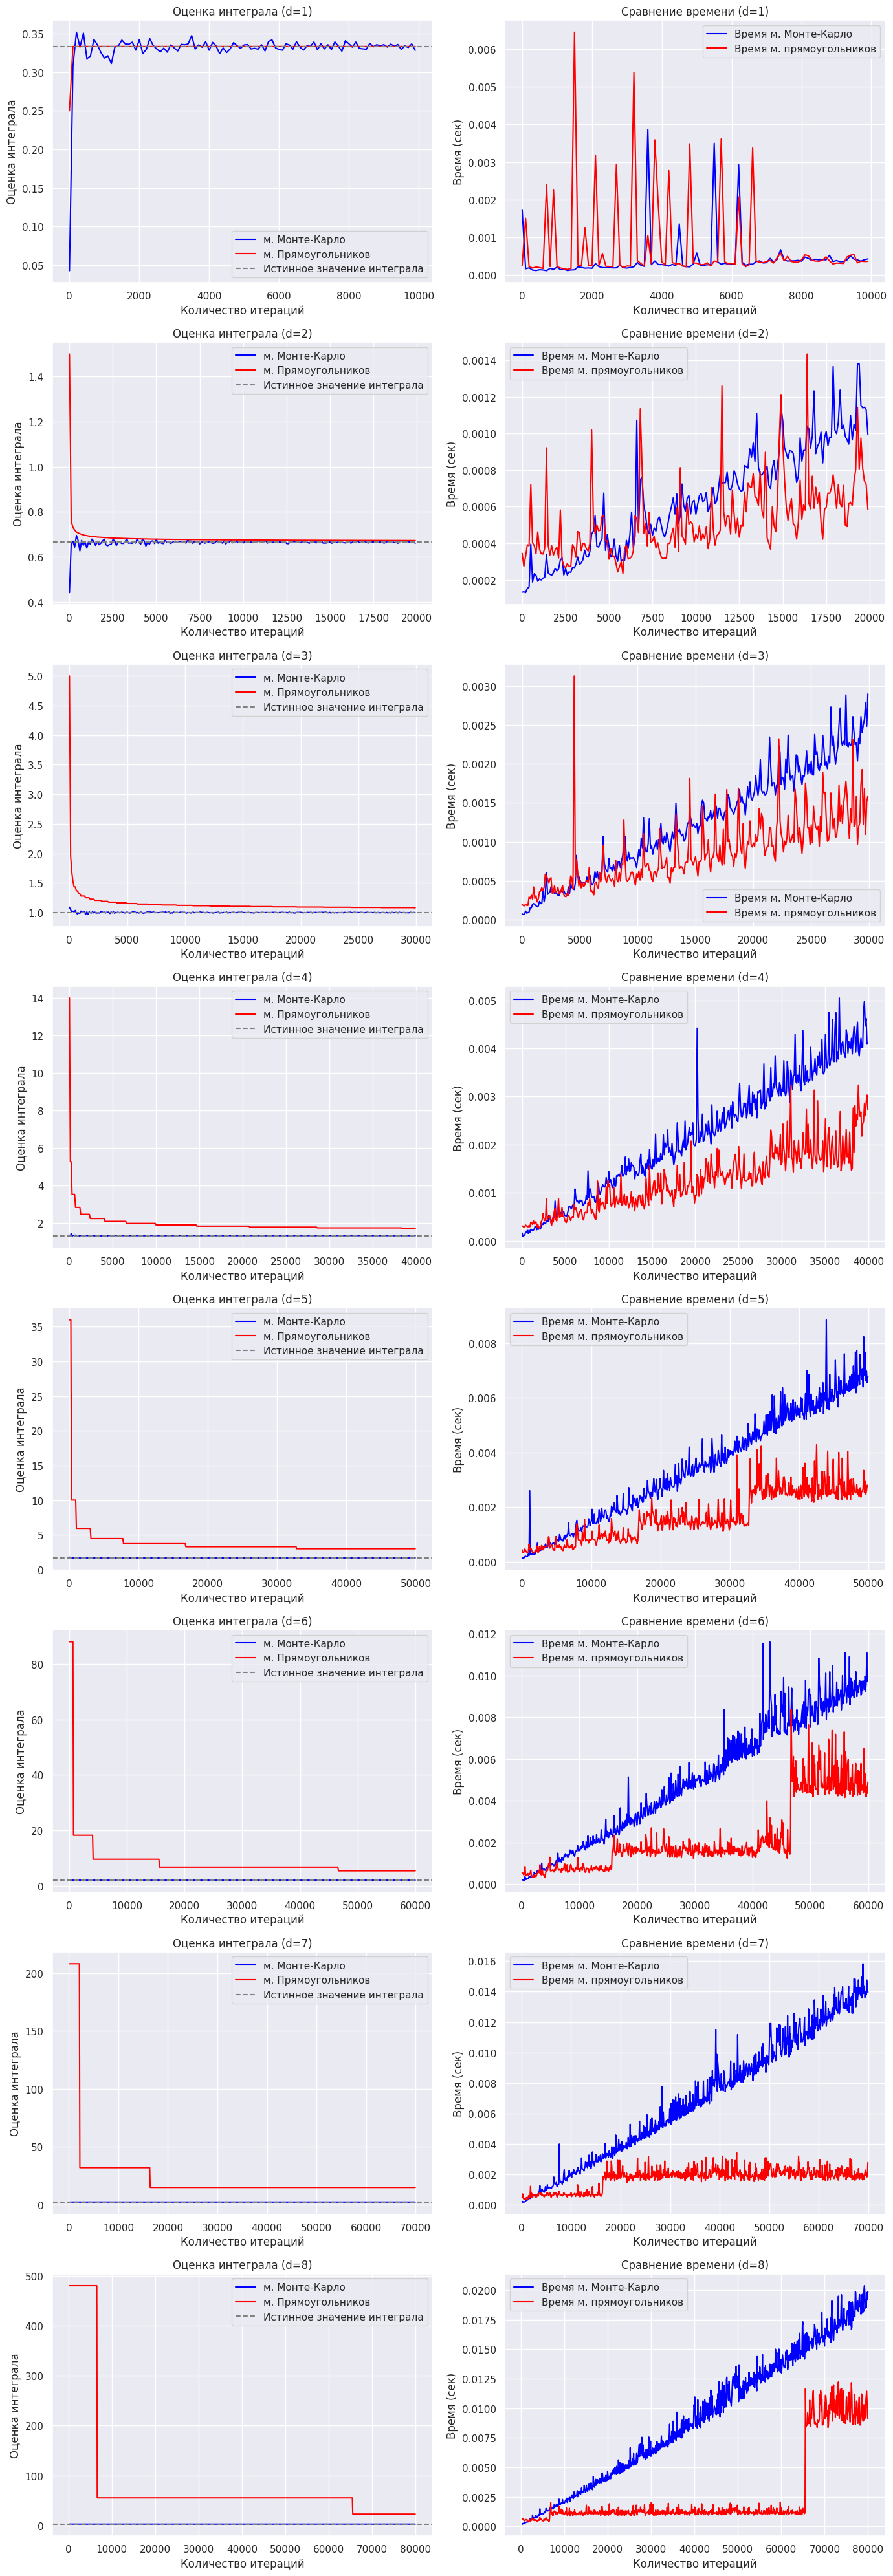

In [9]:
info_for_visualize = []
for d in range(1, 9):
    low = np.array([0 for i in range(d)])
    high = np.array([1 for i in range(d)])
    monte_carlo_results = []
    rectangle_results = []
    n_array = range(2**d, d * 10000, 100)
    for n_iter in n_array:
        task_1_integrator = Integrator()

        monte_carlo_results.append(time_get(
            task_1_integrator.integrate, task_1_func, low, high, n_iter, method="monte_carlo"
        ))

        rectangle_results.append(time_get(
            task_1_integrator.integrate, task_1_func, low, high, n_iter, method="rectangle"
        ))
    info_for_visualize.append([monte_carlo_results, rectangle_results, n_array])
    
visualize_task1(info_for_visualize)

Какой метод и при каких $d$ сходится быстрее? Предположите, в каком случае выгоднее использовать тот или иной метод. С чем связано такое поведение графиков?

**Вывод:** Из графиков видно, что при d = 1, метод прямоугольников сходится быстрее, прочих d МП сильно проигрывает МК. Это связано с тем, что в МП для больших размерностей мы имеем мало точек (так как кол-во точек = (кол-во прямоугольников)^(1/размерность)). При всех d МК занимал больше времени чем МП. Это может быть связано с необходимостью строить случайные распределения точек, в то время как основные арифметические операции достаточно хорошо оптимизированы.

---
## Задача 2.

Оценим константу плотности нормального распределения с помощью численного интегрирования. Тем самым, необходимо оценить интеграл
$$\int\limits_{\mathbb{R}^d} \exp \left( - \frac12 x^Tx \right) dx.$$
При домножении интеграла на эту константу должна получиться единица.

Чему равно истинное значение этой константы?

$С = \frac{1}{\int\limits_{\mathbb{R}^d} \exp \left( - \frac12 x^Tx \right) dx.} $

Прежде чем переходить к оценке, поразмышляйте над следующими вопросами.
1. Что будет, если выбрать слишком большие пределы в методе Монте-Карло? 
2. Что может произойти, если выбрать слишком большие пределы в методе прямоугольников?
3. Что будет, если выбрать слишком маленькие пределы?
4. Какие пределы кажутся оптимальными и почему?

**Ответ:** 
1. Большая часть значений функции будет равна 0, а значит и наша аппроксимация выродится в 0.

2. Аналогично п.1 аппроксимация обнулится.

3. В обоих случаях занчения будут почти равны нулю, т.к. расстояния между точками будут слишком малы. 

4. окружность радиуса 3$\sigma$ с с центром в нуле, далее функция становится пренебрежимой малой.

Сравните результаты работы методов для случаев
* оптимальных пределов,
* слишком больших пределов,
* слишком маленьких пределов.

*Подсказка:* здесь достаточно несколько раз применить написанную ранее реализацию и сделать вывод.

In [10]:
def task_2_func(dots: np.ndarray) -> np.array:
    norms_squared = np.sum(dots**2, axis=1)
    result = np.exp(-0.5 * norms_squared)
    return result

In [11]:
d = 2
lows = [-100000, -10, -0.0001]
highs = [100000, 10, 0.0001]
ways = ["слишком большие пределы", "оптимальные пределы", "слишком маленькие пределы"]
for curr_low, curr_high, way in zip(lows, highs, ways):
    low = np.array([curr_low for i in range(d)])
    high = np.array([curr_high for i in range(d)])
    n_iter = 1000000

    task_2_integrator = Integrator()

    monte_carlo_results = time_get(
        task_2_integrator.integrate,
        task_2_func,
        low,
        high,
        n_iter,
        method="monte_carlo",
    )

    rectangle_results = time_get(
        task_2_integrator.integrate, task_2_func, low, high, n_iter, method="rectangle"
    )

    print("Если: %s" % way)
    print(
        "Результат, полученный методом Монте-Карло: (%.5g, %.4g сек)"
        % (monte_carlo_results[0], monte_carlo_results[1])
    )
    print(
        "Результат полученный методом прямоугольников: (%.5g, %.4g cек)"
        % (rectangle_results[0], rectangle_results[1])
    )

print("Коректное значение: %.5g" % np.sqrt(2 * np.pi) ** d)

Если: слишком большие пределы
Результат, полученный методом Монте-Карло: (0, 0.2032 сек)
Результат полученный методом прямоугольников: (0, 0.1689 cек)
Если: оптимальные пределы
Результат, полученный методом Монте-Карло: (6.2506, 0.09611 сек)
Результат полученный методом прямоугольников: (6.2832, 0.07548 cек)
Если: слишком маленькие пределы
Результат, полученный методом Монте-Карло: (4e-08, 0.09396 сек)
Результат полученный методом прямоугольников: (4.004e-08, 0.07539 cек)
Коректное значение: 6.2832


**Вывод:** Как мы видим, во всех случаях наши предположения оправдались. Заметим, что про оптимальных пределах для 2-мерного случая МП дал оценку лучше чем МК, что согласуется с теорией.

---
## Задача 3.

Некоторая ML-модель имеет один параметр $\theta$, который обучается посредством *максимизации* функции
$$\mathcal{L}(\theta) = \mathsf{E} \exp\left(-\frac{\xi^2\sqrt{\eta}}{1+\theta^2}\right),$$
где $\xi$ имеет стандартное нормальное распределение, а $\eta$ &mdash; пуассоновское распределение с параметром 5 и не зависит от $\eta$.


Оптимизируйте эту функцию, используя стохастический градиентный спуск.

*Подсказка.* Обрати внимание на один из примеров с лекции. Кроме того, заметим, что класс из задачи 1 не подойдет для решения этой задачи. Достаточно написать семплирование непосредственно для этой задачи.

$g(\xi, \eta, \theta) = \exp\left(-\frac{\xi^2\sqrt{\eta}}{1+\theta^2}\right)$

$L'(\theta) = Eg'_\theta(\xi, \eta, \theta) = E exp(-\frac{\xi^2\sqrt{\eta}}{1+\theta^2}) \cdot \frac{2\theta\xi^2\sqrt{\eta}}{(1+\theta)^2}$

В силу УЗБЧ усредненное значение функции с конечным первым моментом сходится п.н. к действительному мат.ожиданию, то вместо подсчета мат ожидания мы будем усреднять значения функции(как впрочем того и требует SGD)

In [12]:
def L(theta, xi, eta):
    return np.exp(-(xi**2) * np.sqrt(eta) / (1 + theta**2))


def grad_L(theta, xi, eta):
    L_theta = L(theta, xi, eta)
    grad = L_theta * (2 * theta * xi**2 * np.sqrt(eta)) / (1 + theta**2) ** 2
    return grad


def sample_xi_eta(n_samples):
    xi = np.random.normal(0, 1, size=n_samples)
    eta = np.random.poisson(5, size=n_samples)
    return xi, eta


def sgd(initial_theta, lr=0.01, num_iterations=1000, num_samples_on_iter=100):
    theta = initial_theta
    theta_history = []
    L_history = []
    for i in range(num_iterations):
        xi, eta = sample_xi_eta(num_samples_on_iter)
        grad = grad_L(theta, xi, eta)
        theta += lr * np.mean(grad)

        theta_history.append(theta)
        L_history.append(L(theta, *sample_xi_eta(1))[0])

    return theta, theta_history, L_history


initial_theta = 1
theta_opt, theta_history, L_history = sgd(initial_theta, 0.1, 50000, 1000)

print("Оптимальное значение θ: %.5g" % theta_opt)

Оптимальное значение θ: 16.904


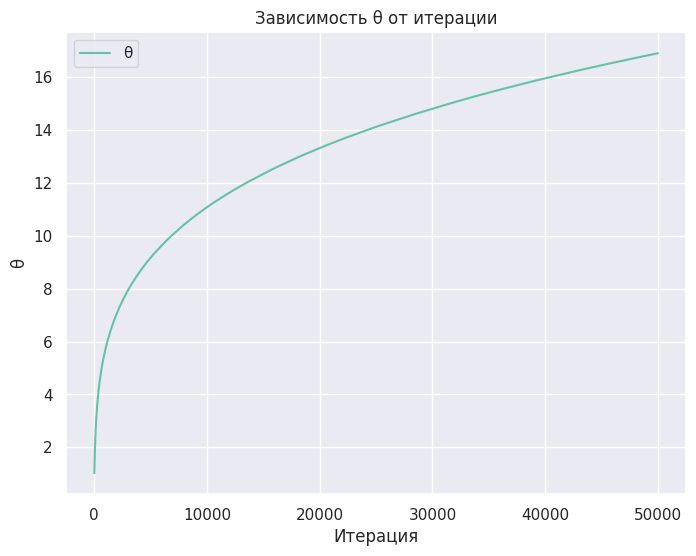

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(theta_history, label="θ")
plt.xlabel("Итерация")
plt.ylabel("θ")
plt.title("Зависимость θ от итерации")
plt.legend()
plt.grid(True)
plt.show()

Как видим, $\theta$ монотонно растет, что согласует с тем, что оптимальным значением для этой задачи является $\theta = \infty$.

___
## Задача 4.
 	
Рассмотрим проект по разработке нефтяного месторождения. В основе модели проекта лежат предварительные данные о величине резервов месторождения.

*Замечание.* Знания физики или экономики не требуются, нужно только внимательно прочитать и расписать все семплирования.



*Формулировка задачи от заказчика:*
Общая задача анализа &mdash; основываясь на величине запасов и проценте нефтеотдачи рассчитать NPV (чистая приведенная стоимость) проекта, а точнее, $0.1$-квантиль ее распределения.
Следующим этапом мы хотим использовать ее в качестве критерия оптимизации, то есть максимизировать такое значение NPV, которого мы можем достигнуть или превысить с $90\%$-й вероятностью, подобрав при этом оптимальное количество скважин на месторождении.



Предположим, что на месторождении есть $n$ скважин. Эти скважины добывают некоторую смесь, которая состоит из воды, нефти и различных примесей. Доля нефти из добытого материала называется <a href="https://ru.wikipedia.org/wiki/Нефтеотдача">коэффициентом нефтеотдачи</a> $k$. Мы будем считать, что этот коэффициент является одинаковым для всего месторождения и имеет нормальное распределение со средним $42\%$ и стандартным отклонением $1.2\%$.




**Добыча нефти скважиной за год**

<a href="http://vseonefti.ru/upstream/stadii-razrabotki.html">Разработка месторождения</a> включает три этапа:
1. фаза роста добычи &mdash; период введения в работу новых скважин;
2. фаза плато: после достижения определенного уровня добычи, она некоторое время продолжается на постоянном уровне;
3. фаза снижения добычи &mdash; период, когда темпы добычи экспоненциально снижаются с течением времени.


Для упрощения задачи мы пропустим два первых этапа и рассмотрим только последний.


Каждая скважина $j$ характеризуется параметром $q_j$ &mdash; темп добычи из скважины, определяемый объемом вещества (смесь нефти, воды и др.), добываемого скважиной за сутки. Будем считать, что этот параметр является одинаковым для скважины в течении всего периода разработки и имеет нормальное распределение со средним $10$ тыс. баррелей и стандартным отклонением $3$ тыс. баррелей. Темпы добычи для разных скважин считаются независимыми случайными величинами.

Соответственно, за год $t$ скважина добывает $Q_{tj} = 365 \cdot k \cdot q_j \cdot e^{-0.008 \cdot n \cdot (t-1)}$ тыс. баррелей нефти, где экспонента отвечает за снижение добычи с течением времени.
Всего за год $t$ на месторождении добывается $Q_t = \sum\limits_{j=1}^{n} Q_{tj}$ тыс. баррелей нефти.




**Прибыль**

Стоимость барреля нефти будем считать постоянной и равной $c = 70$ долларов за баррель. Однако, для расчета стоимости нужно учесть <a href="https://ru.wikipedia.org/wiki/Ставка_дисконтирования">ставку дисконтирования</a> &mdash; процентная ставка, используемая для пересчета будущих потоков доходов в единую величину текущей стоимости (см. формулу далее). Обозначим ее $i$ и будем считать, что она имеет нормальное распределение со средним $10\%$ и стандартным отклонением $1.2\%$.

Стоимость добытой нефти за год $t$ составит (тыс. баррелей)
$$\frac{c \cdot Q_t}{(1+i)^{t-1}}.$$

Будем считать, что разработка месторождения прекращается, если за год на всем месторождении было добыто менее $100$ тыс. баррелей нефти. Последний год разработки обозначим $T$.




**Затраты**

Затраты на месторождение (кроме скважин) составляют $C_{\text{мест.}} = 200$ млн. долларов в год. Будем считать, что издержки на содержание скважины $j$ за весь период разработки имеют треугольное распределение (<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.triang.html">scipy.stats.triang</a>) c минимальным значением $90$ млн. долларов, максимальным значением $120$ млн. долларов и модой (наиболее вероятное значение) $100$ млн. долларов. Обозначим эти случайные величины $C^j_{\text{скв.}}$ и будем считать их независимыми.




**NPV**

Теперь мы можем написать формулу NPV
$$NPV = \sum\limits_{t=1}^T \frac{c \cdot Q_t}{(1+i)^{t-1}} - T \cdot C_{\text{мест.}} - \sum\limits_{j=1}^{n} C^j_{\text{скв.}}.$$




**Задание**

С помощью метода Монте-Карло требуется найти число $x$, при котором $$\mathsf{P}(NPV < x) = 0.1.$$

Количество итераций метода должно быть не менее $100\ 000$. На основе проделанных итераций оцените также среднее значение NPV и вероятность, с которой NPV будет положительна. Кроме того, постройте нормированную гистограмму значений NPV с помощью `plt.hist(values, bins=200, density=True)`.



Перечислим еще раз все *случайные величины*:
* Коэффициент нефтеотдачи $k$ имеет нормальное распределение со средним $42\%$ и стандартным отклонением $1.2\%$;
* $q_1, ..., q_{n}$ &mdash; темпы добычи из скважин &mdash; независимые нормальные случайные величины со средним $10$ тыс. баррелей и стандартным отклонением $3$ тыс. баррелей;
* Ставка дисконтирования $i$ имеет нормальное распределение со средним $10\%$ и стандартным отклонением $1.2\%$;
* $C^1_{\text{скв.}}, ..., C^{n}_{\text{скв.}}$ &mdash; затраты на каждую скважину &mdash; независимые  случайные величины, имеющие треугольное распределение c минимальным значением $90$ млн. долларов, максимальным значением $120$ млн. долларов и модой (наиболее вероятное значение) $100$ млн. долларов (используйте `sps.triang(loc=90, c=1/3, scale=30)`).

Параметры считать независимыми.

*Фиксированные параметры*:
* $n = 25$ скважин;
* $365$ дней в году;
* $c=70$ долларов за баррель &mdash; стоимость нефти;
* $100$ тыс. баррелей &mdash; объем добытой нефти за год, при котором разработка месторождения прекращается;
* $200$ млн. долларов в год &mdash; затраты на месторождение.

*Замечания по решению*:
* Все случайные величины надо сгенерировать заранее, до вычисления значений $T$.
* Не стоит выводить явную формулу для $T$, **используйте цикл по годам**.
* Запрещается использовать цикл по количеству элементов в выборке.

**Решение:**

Выпишем основные константы

In [14]:
n = 25
c = 70
marginal_prod = 100
C_field = 200

Сформируем функцию, которая будет выдавать итоговый доход от месторождения(в млн. долларах).

In [15]:
def get_NPV_vectorized(num_iterations):
    k = np.random.normal(0.42, 0.012, size=num_iterations)
    qs = np.random.normal(10, 3, size=(num_iterations, n))
    i = np.random.normal(0.10, 0.012, size=num_iterations)
    C_well_s = sps.triang(loc=90, c=1/3, scale=30).rvs(size=(num_iterations, n))

    T = -1
    t = 1
    Q_1 = np.sum(365 * k[:, None] * qs, axis=1)
    Q_t = Q_1
    Income = np.zeros(num_iterations)

    while np.any(Q_t > marginal_prod):
        active = Q_t > marginal_prod
        Income[active] += (c / 1000000) * (Q_t[active] * 1000) / (1 + i[active]) ** (t - 1)
        t += 1
        Q_t = np.sum(365 * k[:, None] * qs * np.exp(-0.008 * n * (t - 1)), axis=1)

    T = t - 1
    NPV = Income - T * C_field - np.sum(C_well_s, axis=1)
    return NPV

Теперь при помощи МК постараемся найти оптимальный x.

In [16]:
def get_quantile(data, quantile):
    data_sorted = np.sort(data)
    index = int(quantile * len(data))
    return data_sorted[index]

<b><font color="#00b565"> ИСПРАВИЛ КОД</font></b>

<b><font color="#00b565"> Замечание </font></b>: Код содержит циклы.        . Комм. Написан код с циклом по числу элементов в выборке. 

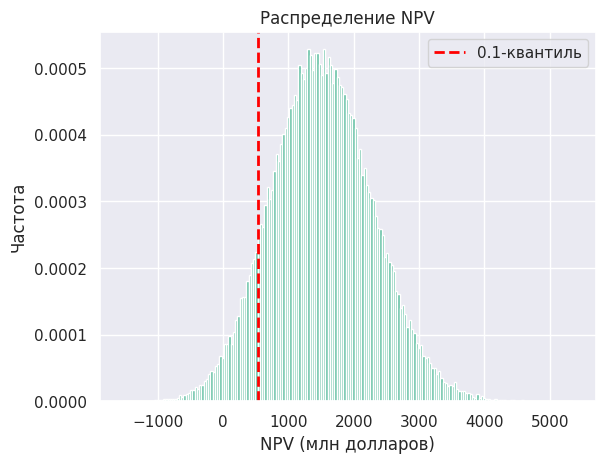

0.1-квантиль NPV: 537.11 млн долларов
Среднее значение NPV: 1518.06 млн долларов
Вероятность положительного NPV: 0.97855


In [19]:
num_iterations = 100000
npvs = get_NPV_vectorized(num_iterations)

quantile_0_1 = get_quantile(npvs, 0.1)
mean_npv = np.mean(npvs)
positive_prob = np.mean(npvs > 0)

plt.hist(npvs, bins=200, density=True)
plt.axvline(x=quantile_0_1, color='r', linestyle='--', linewidth=2, label='0.1-квантиль')
plt.xlabel('NPV (млн долларов)')
plt.ylabel('Частота')
plt.title('Распределение NPV')
plt.legend()
plt.show()

print('0.1-квантиль NPV: %.2f млн долларов' % quantile_0_1)
print('Среднее значение NPV: %.2f млн долларов' % mean_npv)
print('Вероятность положительного NPV: %g' % positive_prob)

<b><font color="#00b565"> КОНЕЦ ИСПРАВЛЕНИЙ</font></b>

**Вывод:** Как мы видим, МК вполне адекватно смого справится с рассчетом достаточно многоуровневой задачи, что говорит о широком спектре его применения.